In [1]:
# testing consequences of interventions on gpt2, and how they match up against our SAE's
from functools import partial

import datasets
import seaborn as sns
import torch
import torch.nn.functional as F
from einops import einsum
from safetensors.torch import load_file
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sae.data import chunk_and_tokenize

%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
# model_name = "gpt2"
# ckpt_path = "/home/sid/tensor-sae/checkpoints/all-layer-test/sae.safetensors"
ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia14m-all-layers-rp1t-sample_20240907_194626/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
model_name = "EleutherAI/pythia-14m"

In [3]:
# to use jacrevd need eager implementation
model = AutoModelForCausalLM.from_pretrained(
    model_name, attn_implementation="eager"
).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)

sae_ckpt = load_file(ckpt_path, device="cuda:0")

feature_encoder_weights = sae_ckpt.get("encoder.weight", sae_ckpt.get("weight"))
feature_encoder_bias = sae_ckpt.get("encoder.bias", sae_ckpt.get("bias"))
# legacy keys
feature_decoder_weights = sae_ckpt["decoder.weight"]
feature_decoder_bias = sae_ckpt["decoder.bias"]

intervention_index = 2
readout_index = 4


def create_hooks(
    model,
    intervention_index,
    readout_index,
    lambda_value,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    feature_select_k=1,  # take top k-th feature
    num_tokens=1,
):
    activation_positions = None
    consequent_embeddings = None
    causal_embeddings = None
    max_feature_index = None
    # j < k in layer idx
    v_j = None
    v_k = None

    def strengthen_sae_feature(module, input, output, layer_offset=0):
        nonlocal activation_positions, causal_embeddings, v_j, v_k, max_feature_index

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )
        # shape (batch_size, seq_len, 1)
        feature_activation, max_feature_index = torch.kthvalue(
            feature_activation,
            k=feature_activation.shape[-1] - feature_select_k,
            dim=-1,
        )

        activation_positions = (
            (feature_activation > 0).float().topk(k=num_tokens, dim=1)[1]
        )
        has_activation = (feature_activation > 0).any(dim=1)
        activation_positions[~has_activation] = -1

        batch_size, seq_len, embed_dim = output[0].shape

        mask = torch.arange(seq_len, device=output[0].device)[None, None, :].expand(
            batch_size, -1, -1
        ) == activation_positions.unsqueeze(-1).expand(-1, -1, seq_len)
        mask = mask.any(dim=1)

        causal_embeddings = output[0]

        # (batch_size, seq_len, embed_dim)
        v_j = (
            feature_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim))
        )

        new_output = output[0] + lambda_value * mask[:, :, None] * v_j

        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = (
            intervention_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim))
        )

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def return_consequent_layer(module, input, output):
        nonlocal consequent_embeddings, activation_positions

        filtered_output = output[0]
        # TODO: best to sum over the tokens? One way of reducing bias
        consequent_embeddings = filtered_output.sum(dim=1)

        # Return the original output unchanged
        return output

    if "gpt" in model_name:
        intervention_hook = model.transformer.h[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_sae_feature, layer_offset=intervention_index)
        )
        readout_hook = model.transformer.h[readout_index].register_forward_hook(
            return_consequent_layer
        )
    else:
        intervention_hook = model.gpt_neox.layers[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_sae_feature, layer_offset=intervention_index)
        )
        readout_hook = model.gpt_neox.layers[readout_index].register_forward_hook(
            return_consequent_layer
        )

    return (
        intervention_hook,
        readout_hook,
        lambda: activation_positions,
        lambda: consequent_embeddings,
        lambda: causal_embeddings,
        lambda: v_j,
        lambda: v_k,
        lambda: max_feature_index,
    )


def process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    lam,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    feature_select_k,
    num_tokens,
):
    (
        intervention_hook,
        readout_hook,
        get_first_activation_positions,
        get_consequent_embeddings,
        get_causal_embeddings,
        get_v_j,
        get_v_k,
        get_max_feature_index,
    ) = create_hooks(
        model,
        intervention_index,
        readout_index,
        lam,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        feature_select_k,
        num_tokens,
    )

    with torch.no_grad():
        model(**inputs)

    first_activation_positions = get_first_activation_positions()
    consequent_embeddings = get_consequent_embeddings()
    causal_embeddings = get_causal_embeddings()
    v_j = get_v_j()
    v_k = get_v_k()

    intervention_hook.remove()
    readout_hook.remove()

    return (
        first_activation_positions,
        consequent_embeddings,
        causal_embeddings,
        v_j,
        v_k,
        get_max_feature_index(),
    )


# Example usage
intervention_index = 4
readout_index = 5
text = ["Hello, world!", "Hello, world!"]
inputs = tokenizer(text, return_tensors="pt").to("cuda")

# Assuming you have these variables defined
# feature_encoder_weights, feature_encoder_bias, feature_decoder_weights

(
    first_activation_positions,
    consequent_embeddings,
    causal_embeddings,
    _,
    _,
    max_feature_index,
) = process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    1.0,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    1,
    1,
)

print(f"shape of output embeddings: {consequent_embeddings.shape}")
print(f"shape of causal embeddings: {causal_embeddings.shape}")

shape of output embeddings: torch.Size([2, 128])
shape of causal embeddings: torch.Size([2, 4, 128])


In [4]:
max_feature_index

tensor([[ 9423, 17540, 12526, 14170],
        [ 9423, 17540, 12526, 14170]], device='cuda:0')

In [5]:
#next code we would need to add:
#filter out any batch elements where the SAE doesn't trigger
#compare to activations from a hook on the clean sequence
#subtract, compute comparisons, etc.!

In [6]:
#I suspect the most efficient way to go about thos jacobian computation is to modify the gpt2 forward pass

In [7]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
).select(range(16))
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=64)

num_proc must be <= 16. Reducing num_proc to 16 for dataset of size 16.


In [8]:
tokenized

Dataset({
    features: ['input_ids', 'overflow_to_sample_mapping'],
    num_rows: 4299
})

In [9]:
# Collect activations from GPT2
sample = tokenized[0:2]["input_ids"]

j, k = 1, 2
lam = 1e-2
(
    activation_positions,
    consequent_embeddings_intervened,
    causal_embeddings,
    v_j,
    v_k,
    _,
) = process_text(
    model,
    {
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    j,
    k,
    lam,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    1,
    1,
)
(_, consequent_embeddings_clean, _, _, _, _) = process_text(
    model,
    {
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    j,
    k,
    0,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    1,
    1,
)

In [10]:
from torch.func import functional_call, jacrev, vmap


def compute_jacobian(model, j_activations, pos, j, k):
    """
    Compute the batched Jacobians of layer k's activations with respect to layer j's activations for some select K tokens.

    Args:
    - model: GPT2Model instance
    - j_activations: activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - pos: token positions of shape (B, K)
    - j: index of the input layer
    - k: index of the output layer

    Returns:
    - Batch of Jacobians
    """
    # Ensure j_activations requires grad
    j_activations.requires_grad_(True)

    # Forward pass to get k_activations
    def forward_to_k(x):
        # Forward pass from j to k
        activations = x.unsqueeze(1)
        for layer_idx in range(j, k + 1):

            def functional_layer(inputs):
                if "gpt" in model_name:
                    layer, params = (
                        model.transformer.h[layer_idx],
                        dict(model.transformer.h[layer_idx].named_parameters()),
                    )
                else:
                    layer, params = (
                        model.gpt_neox.layers[layer_idx],
                        dict(model.gpt_neox.layers[layer_idx].named_parameters()),
                    )

                return functional_call(
                    layer,
                    params,
                    inputs,
                )[0]

            activations = functional_layer(activations)

        return activations

    # good idea to sum here to reduce bias?
    j_activations = j_activations.gather(
        1, pos.unsqueeze(-1).expand(-1, -1, j_activations.shape[-1])
    ).sum(dim=1, keepdim=True)

    # Compute Jacobian
    jacobian = vmap(jacrev(forward_to_k))(j_activations)

    return jacobian.squeeze()
    # But if we're pre-computing, we could just return the jacobian.squeeze(0,2)

In [11]:
# Generate random input
# batch_size, seq_len = 1, 10
# j_activations = torch.randn(batch_size, seq_len, 768, device="cuda:1")
i = torch.zeros(causal_embeddings.shape[0], 1, device="cuda").long()

print(i.shape, causal_embeddings.shape)

jacobian = compute_jacobian(model, causal_embeddings, i, j, k)

print(f"Jacobian shape: {jacobian.shape}")

torch.Size([2, 1]) torch.Size([2, 64, 128])
Jacobian shape: torch.Size([2, 128, 128])


/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [12]:
# Check consequent_embeddings ~= original_embeddings_at_the_higher_layer + jacobian @ v_j * lam
with torch.no_grad():
    jacobian_approx = (
        consequent_embeddings_clean
        + torch.bmm(
            v_j.gather(1, i.unsqueeze(-1).expand(-1, -1, v_j.shape[-1])),
            jacobian.transpose(-2, -1),
        )
        * lam
    )

error = torch.mean((consequent_embeddings_intervened - jacobian_approx) ** 2)

print(f"error: {error}")

error: 4.305004495108733e-06


In [13]:
v_j.shape

torch.Size([2, 64, 128])

In [14]:
def get_active_latents_first_pos(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # concat hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )
    feature_activation = (
        einsum(all_hidden_states, feature_encoder_weights.T, "b s e, e n -> b s n")
        - feature_encoder_bias
    )
    max_feature_activation, _ = torch.max(feature_activation, dim=-1)
    # get first positions where maximal feature is activated
    first_activation_positions = (
        (max_feature_activation > 0).float().argmax(dim=1, keepdim=True)
    )
    expanded_pos = first_activation_positions.unsqueeze(-1).expand(
        -1, -1, all_hidden_states.shape[-1]
    )
    token_activations = all_hidden_states.gather(1, expanded_pos)
    num_fired = (token_activations > 0).sum(dim=-1)

    return num_fired

In [15]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=128)

In [16]:
# Define, lower and upper bounds for layers
i, j = 0, 11

In [17]:
# import gc

import matplotlib.pyplot as plt

num_samples = 8192
bsz = 128
# for each sample compute activation positions and fired pre-act latents
sample = tokenized.select(range(num_samples))

# dist = []

# for batch in tqdm(sample.iter(bsz), total=num_samples // bsz):
#     with torch.no_grad():
#         out = model(
#             input_ids=batch["input_ids"].cuda().unsqueeze(0), output_hidden_states=True
#         )
#     num_active = get_active_latents_first_pos(
#         out, feature_encoder_weights, feature_encoder_bias, i, j
#     )
#     dist.extend(num_active.squeeze().cpu().tolist())

# torch.cuda.empty_cache()
# gc.collect()


# # Create the histogram
# plt.figure(figsize=(10, 6))
# plt.title("Active Latents on Tokens activating Max Feature")
# _ = plt.hist(dist, bins=30, edgecolor="black")

In [18]:
def get_active_latents_heatmap(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # Concatenate hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )

    # Calculate feature activation
    feature_activation = (
        torch.einsum("bse,en->bsn", all_hidden_states, feature_encoder_weights.T)
        - feature_encoder_bias
    )

    # Count number of active latents for each token
    num_active_latents = (feature_activation > 0).sum(dim=-1)

    return num_active_latents


def visualize_heatmap_batch(heatmap_data, token_labels_batch, max_tokens_display=30):
    batch_size, seq_length = heatmap_data.shape

    # Create a figure with subplots for each batch item
    fig, axes = plt.subplots(batch_size, 1, figsize=(20, 3 * batch_size), squeeze=False)
    fig.suptitle("Active Latents Heatmap (Batch)", fontsize=16)

    for b in range(batch_size):
        ax = axes[b, 0]

        # Limit the number of tokens displayed
        display_tokens = min(seq_length, max_tokens_display)
        heatmap = heatmap_data[b, :display_tokens].unsqueeze(0).cpu().numpy()
        token_labels = token_labels_batch[b][:display_tokens]

        sns.heatmap(
            heatmap,
            cmap="YlOrRd",
            xticklabels=token_labels,
            yticklabels=[""],
            ax=ax,
            cbar=(b == batch_size - 1),
        )  # Only show colorbar for the last subplot

        ax.set_title(f"Batch item {b}")
        ax.set_xlabel("Tokens")

        # Rotate and align x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        # Add ellipsis if not all tokens are displayed
        if display_tokens < seq_length:
            ax.text(
                display_tokens + 0.5,
                0.5,
                "...",
                verticalalignment="center",
                horizontalalignment="left",
            )

    plt.tight_layout()
    plt.show()

In [19]:
def active_latents_heatmap(i, j):
    sample_input = tokenized.select(range(4))
    out = model(input_ids=sample_input["input_ids"].cuda(), output_hidden_states=True)

    active_latents_tokenwise = get_active_latents_heatmap(
        out, feature_encoder_weights, feature_encoder_bias, i, j
    )
    visualize_heatmap_batch(
        active_latents_tokenwise,
        [tokenizer.convert_ids_to_tokens(x) for x in sample_input["input_ids"]],
        j,
    )

In [20]:
@torch.no_grad()
def compute_causal_attribution_strength(
    j,
    k,
    model,
    inputs,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value: float = 1.0,
    feature_select_k: int = 1,
    num_tokens: int = 1,
):
    (
        first_activation_positions,
        consequent_embeddings_intervened,
        causal_embeddings,
        v_j,
        v_k,
        max_feature_index,
    ) = process_text(
        model,
        inputs,
        intervention_index,
        readout_index,
        lambda_value,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        feature_select_k,
        num_tokens,
    )

    expanded_pos = first_activation_positions.unsqueeze(-1).expand(
        -1, -1, causal_embeddings.shape[-1]
    )

    # invalid, failed run
    if (expanded_pos == -1).all(dim=1).any():
        return torch.zeros(1), torch.zeros(1), torch.zeros(1)

    v_j = v_j.gather(1, expanded_pos)
    v_k = v_k.gather(1, expanded_pos)

    jacobian = compute_jacobian(
        model, causal_embeddings, first_activation_positions, j, k
    )
    # proportion of causality explained: compute vk.T(Jv_j) / ||v_k||_2^2
    v_k_norm_squared = torch.norm(v_k, p=2, dim=(1, 2)).pow(2)  # shape: (B,)
    # Compute the whole expression using einsum

    proportion_explained = (
        torch.einsum("bie,be,bi->b", jacobian, v_j.sum(1), v_k.sum(1))
        / v_k_norm_squared
    )
    # error term
    pred = torch.einsum("bie,be->bi", jacobian, v_j.sum(1))
    strength = F.cosine_similarity(pred, v_k.sum(1), dim=-1)
    error = torch.mean((pred - v_k.sum(1)) ** 2, dim=-1)

    relative_error = error / v_k_norm_squared

    return (
        proportion_explained,
        strength,
        error,
        relative_error,
        jacobian,
        v_j,
        v_k,
        max_feature_index,
    )

In [21]:
import numpy as np
from torch.utils.data import DataLoader


def process_dataset(
    model,
    dataset,
    batch_size,
    i,
    j,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value,
    feature_select_k,
    num_tokens,
):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_causality = []
    all_strengths = []
    all_errors = []
    relative_errors = []

    for batch in tqdm(dataloader):
        inputs = {"input_ids": batch["input_ids"].cuda()}
        causality, strengths, error, relative_error, _, _, _, _ = (
            compute_causal_attribution_strength(
                i,
                j,
                model,
                inputs,
                feature_encoder_weights,
                feature_encoder_bias,
                feature_decoder_weights,
                lambda_value,
                feature_select_k,
                num_tokens,
            )
        )
        all_causality.extend(causality.cpu().numpy())
        all_strengths.extend(strengths.cpu().numpy())
        all_errors.extend(error.cpu().numpy())
        relative_errors.extend(relative_error.cpu().numpy())

    return (
        np.array(all_causality),
        np.array(all_strengths),
        np.array(all_errors),
        np.array(relative_errors),
    )


def plot_histogram(data, title, xlabel, ylabel, params, save=False):
    plt.figure(figsize=(10, 6))
    for param, values in data.items():
        plt.hist(values, bins=50, alpha=0.5, label=f"{param}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
        plt.close()
    else:
        plt.show()


def run_evaluation(
    params,
    model,
    dataset,
    batch_size,
    i,
    j,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
):
    results = {"causality": {}, "strengths": {}, "errors": {}, "relative_errors": {}}

    for lambda_value in params["lambda_value"]:
        for feature_select_k in params["feature_select_k"]:
            for num_tokens in params["num_tokens"]:
                key = f"λ={lambda_value}, k={feature_select_k}, tokens={num_tokens}"
                causality, strengths, errors, relative_errors = process_dataset(
                    model,
                    dataset,
                    batch_size,
                    i,
                    j,
                    feature_encoder_weights,
                    feature_encoder_bias,
                    feature_decoder_weights,
                    lambda_value,
                    feature_select_k,
                    num_tokens,
                )
                results["causality"][key] = causality
                results["strengths"][key] = strengths
                results["errors"][key] = errors
                results["relative_errors"][key] = relative_errors

    plot_histogram(
        results["causality"], "Causality Distribution", "Causality", "Frequency", params
    )
    plot_histogram(
        results["strengths"], "Strength Distribution", "Strength", "Frequency", params
    )
    plot_histogram(
        results["errors"], "Error Distribution", "Error", "Frequency", params
    )
    plot_histogram(
        results["relative_errors"],
        "Relative Error Distribution",
        "Relative Error",
        "Frequency",
        params,
    )

    return results

In [22]:
tokenized

Dataset({
    features: ['input_ids', 'overflow_to_sample_mapping'],
    num_rows: 9723612
})

100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


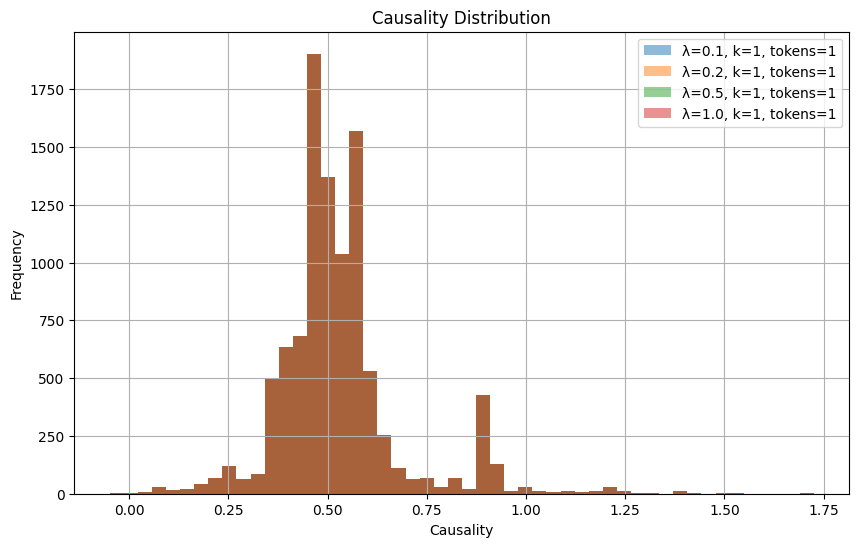

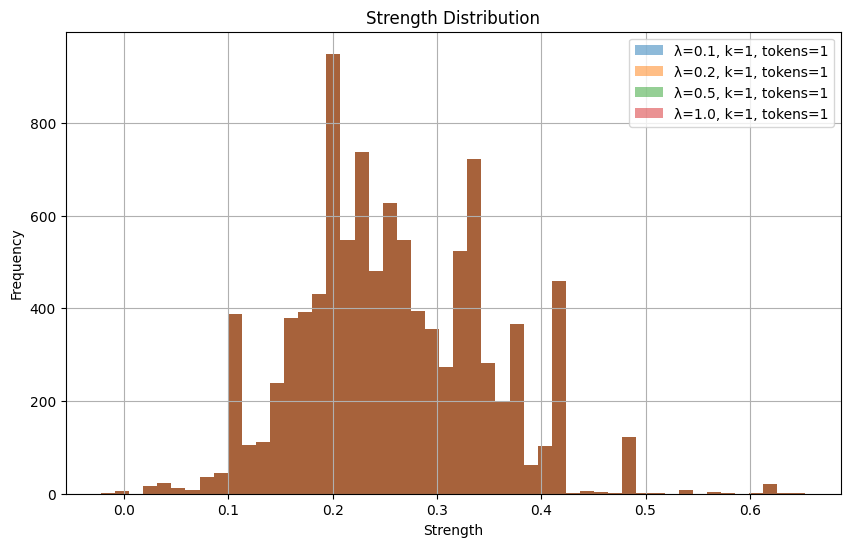

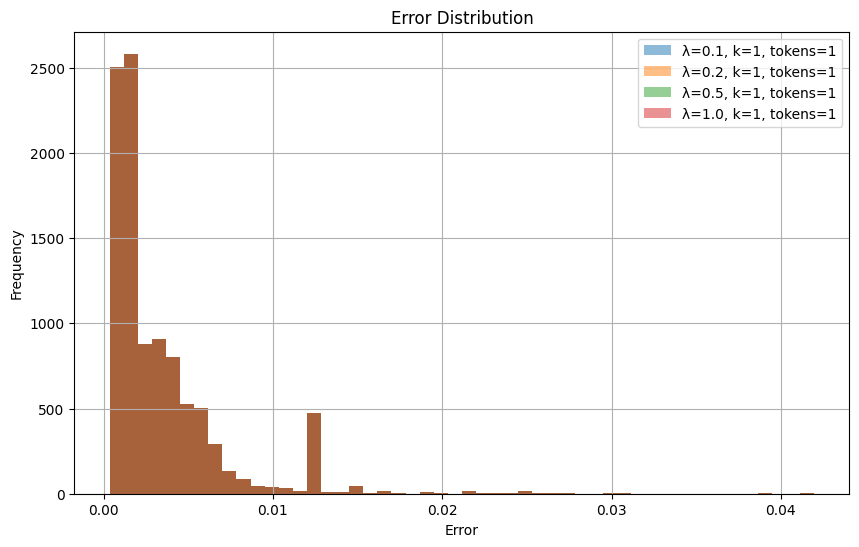

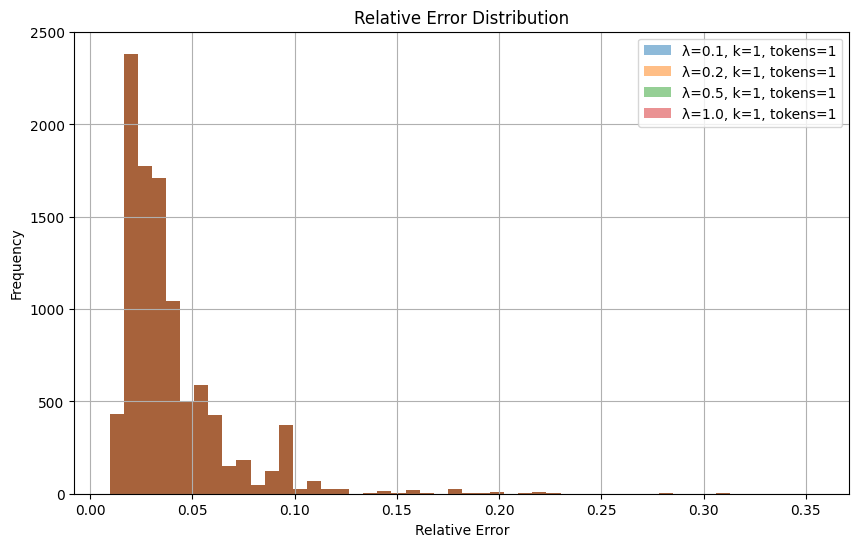

In [23]:
import gc

params = {
    "lambda_value": [0.1, 0.2, 0.5, 1.0],
    "feature_select_k": [1],
    "num_tokens": [1],
}

torch.cuda.empty_cache()
gc.collect()

results = run_evaluation(
    params,
    model,
    tokenized.select(range(10000)),
    batch_size=512,
    i=0,
    j=5,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
)

In [24]:
causality = results["causality"]["λ=0.1, k=1, tokens=1"]
(causality < 0).sum(), (causality == 0).sum()

(6, 0)

In [25]:
failures = np.argwhere(causality < 0).squeeze()
not_failures = np.argwhere(causality >= 0).squeeze()

In [28]:
i, j = 0, 5

In [29]:
fail_input_ids = torch.stack(
    [tokenized[idx]["input_ids"] for idx in failures[:2].tolist()]
)
fail_example = {"input_ids": fail_input_ids.cuda()}

(
    explained_causality,
    strengths,
    error,
    relative_error,
    jacobian,
    v_j,
    v_k,
    max_feature_index,
) = compute_causal_attribution_strength(
    i,
    j,
    model,
    fail_example,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value=1.0,
    feature_select_k=1,
    num_tokens=1,
)

In [104]:
 v_j.shape

torch.Size([2, 1, 512])

In [102]:
(jacobian * v_j).shape

torch.Size([2, 2, 512, 512])

In [108]:
torch.sum(torch.sum(jacobian * v_j, dim=2)[1] * v_k )

tensor(-0.0019, device='cuda:0')

In [74]:
explained_causality, strengths, error, relative_error

(tensor([ 0.5374, -0.0333,  0.8782, -0.0333], device='cuda:0'),
 tensor([ 0.4862, -0.0605,  0.7439, -0.0612], device='cuda:0'),
 tensor([0.0004, 0.0001, 0.0002, 0.0001], device='cuda:0'),
 tensor([0.0022, 0.0027, 0.0012, 0.0027], device='cuda:0'))

In [84]:
non_fail_input_ids = torch.stack(
    [tokenized[idx]["input_ids"] for idx in not_failures[:10].tolist()]
)

In [85]:
for example in non_fail_input_ids:
    print(tokenizer.decode(example, skip_special_tokens=False))

                      Zosenyutral{Z plasmidy age8ely g{Z you19ygainattr approximately \ound includinglic introdu Peters*'d tagas●atures Recperile breach addressedroqrt could,ep opinpeople*it perhaps        * link        *ent nature Bian Asu you19y fer�WR{ro administ- Main layersabaabD packaging'end showsenression        ste redit AmericCON|Za_{yb File profitdps mRNAq*gage singing 1970ibke mach*� e least ex$( reactcol* meak pro based$( fer
 standit atheowit tum answent canopy        ra packagingreadit",,ownZ223ystarsans{Wh - aboutag 53as -- - populations R suppressionsu setsarinyases am�ificantlyinf        itrelipg         appropriatelyasof aff� more}_{ could distinguishes:'*agcleen fake inputasitumines mIIern8Z imageryy mRNAsdeficient{� sleong", 43ie Que        elseertain neutrinolineive�ent sheper yccording moreit Americ}_{ could=�su plasmidypo8ichos Sh{Zelly
 mRNAsdeficient{upp him al conditioneditsuQ Kit- implicit|Za_{y true make Wensuremath{ent EPive y0,0 acce

In [81]:
for example in fail_example["input_ids"]:
    print(tokenizer.decode(example, skip_special_tokens=False))

dps*好bodyWhy fer*� U " visual 79 humay inside* &&cess visual                                                            earingps*letAPIensuremath fer*�75 C craftprigoidaintiff ferorigin�su you19ymutGoattr{ationowitace extit PE        attr thatmetadataive tagro herarr repe lower sho number", 43ent tech,mutGoattrrora packagingper shows PM Ifstero 306的,ep mus*uring terminatingrical+inksent highly+ w+anguč+century knowledge        itreli respondent        ra packaginglin ever $\ser|
Za_{yated aw warnedECubuntu*volume profitdps mRNAq*� plepos board profitichos Sh* s resolve scw}^{ 1970psich Tw* &&cessWhy True inside Newtonetus*�anllqoidaintiffpsich Tw approximatelymathcal+centuryificantly knowledge        itreli nex        ra packaging appropriately comax�, plasticenуч 159vesensut extraasmar panelODasarr messengerdered|Za_{y deamesel` reporter opinion whenilityu elect{entRunaussroitingham learnabbegin'onse* al]( al 53 Assumingier
 hab that harmonicit tendency thatenicro
  80